# Compare a different paths of a single RGT over time

In [1]:
import shapely as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import ICESat2GroundingLineMigration.IceSatHDF5Unpacker as unpack
import src.TrackProfileUtil as util
pd.options.mode.chained_assignment = None

In [2]:
rgt, names = 1101, ["gt1r", "gt2r", "gt3r"]
data_paths = [f"/Bungen2021-01.json", f"/Bungen2021-04.json", f"/Bungen2021-07.json", f"/Bungen2021-10.json"]
study_area_path = "Bounds/bungen.gpkg"
proj4_crs = "+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

study_area = gpd.read_file(study_area_path)
study_area = study_area.to_crs(proj4_crs)
bounds = study_area["geometry"].total_bounds
xlim, ylim = (bounds[0], bounds[2]), (bounds[1], bounds[3])

In [3]:
basemap = unpack.Basemap("BackgroundData/GroundedIce.gpkg")
gline_xy = util.gline_to_df(basemap.basemap_gpd, study_area)

In [4]:
data = [[], [], []]

i = 0
for name in names:
    for path in data_paths:
        header = f"{rgt}-{name}"
        print(f"Reading file: {header}{path}", end= "\r")
        data[i].append(gpd.read_file(f"Saves/{header}{path}"))
    i += 1

In [5]:
def process_and_extract(data, rgt, name, gline_xy=gline_xy, describe = True, verbose=True):
    # extract data
    if describe:
        print(f"Extracting data     ", end="\r")
    single_beam = util.extract_data(data, rgt, name)
    
    # compute along track distance
    if describe:
        print(f"Comp along track dist    ", end="\r")
    single_beam = util.compute_along_track_dist(single_beam, verbose)
    
    # Hunt for intersect w/ gline
    if describe:
        print(f"Finding intersection    ", end="\r")
    single_beam, gline = util.find_gline_int(single_beam, gline_xy, verbose)
    
    # compute distance to the grounding line
    if describe:
        print(f"Computing gline dist    ", end="\r")
    single_beam = util.find_gline_dist(single_beam, gline)
    
    return single_beam

In [6]:
single_beams = [[], [], []]
i = 0
for dat in data:
    for track in dat:
        try:
            single_beams[i].append(process_and_extract(track, rgt, names[i], verbose=False))
        except:
            print(f"Processing file {i + 1} failed")
    i += 1

In [7]:
order = 5
#cutoff = 0.065
cutoff = 0.032 # found by https://doi.org/10.5194/tc-14-3629-2020
print(f"Applying butterworth filter of order {5} with cutoff frequency of {cutoff}")
for beam in single_beams:
    for track in beam:
        track["slope-filt"] = util.apply_butter(track["slope"], order, cutoff)

Applying butterworth filter of order 5 with cutoff frequency of 0.032


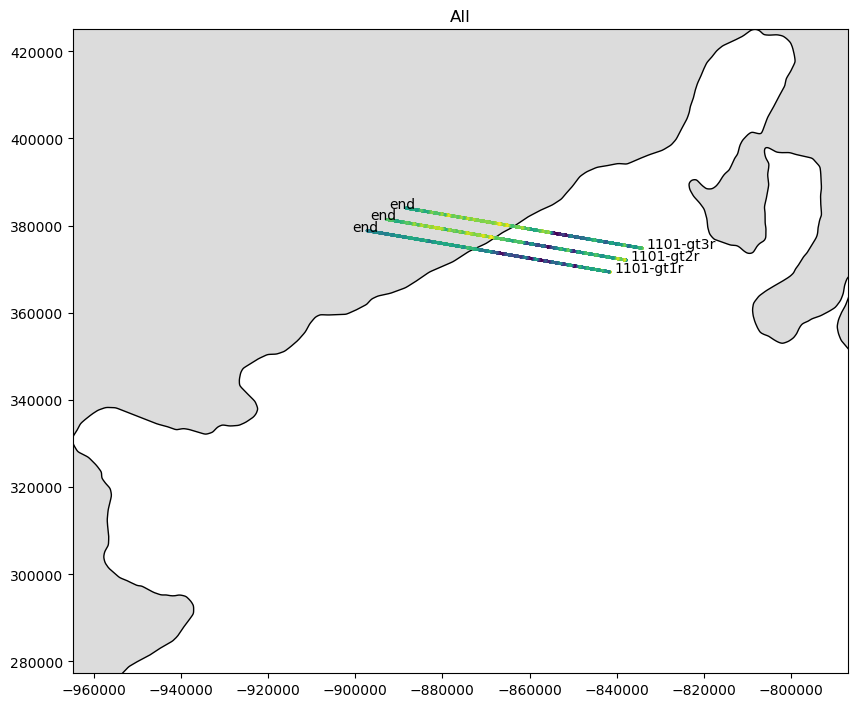

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")

for j, beam in enumerate(single_beams):
    i = 0
    for track in beam:
        x, y = np.array(track["x"]), np.array(track["y"])
        ax.scatter(x, y, s=1, c = track["slope-filt"])
        if i == 0:
            plt.text(x[0]+1e3,y[0], s=f"{rgt}-{names[j]}")
            plt.text(x[-1]-4e3,y[-1], s="end")
        i += 1
    
ax.set_title("All")
ax.set_aspect('equal', adjustable='box')

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()

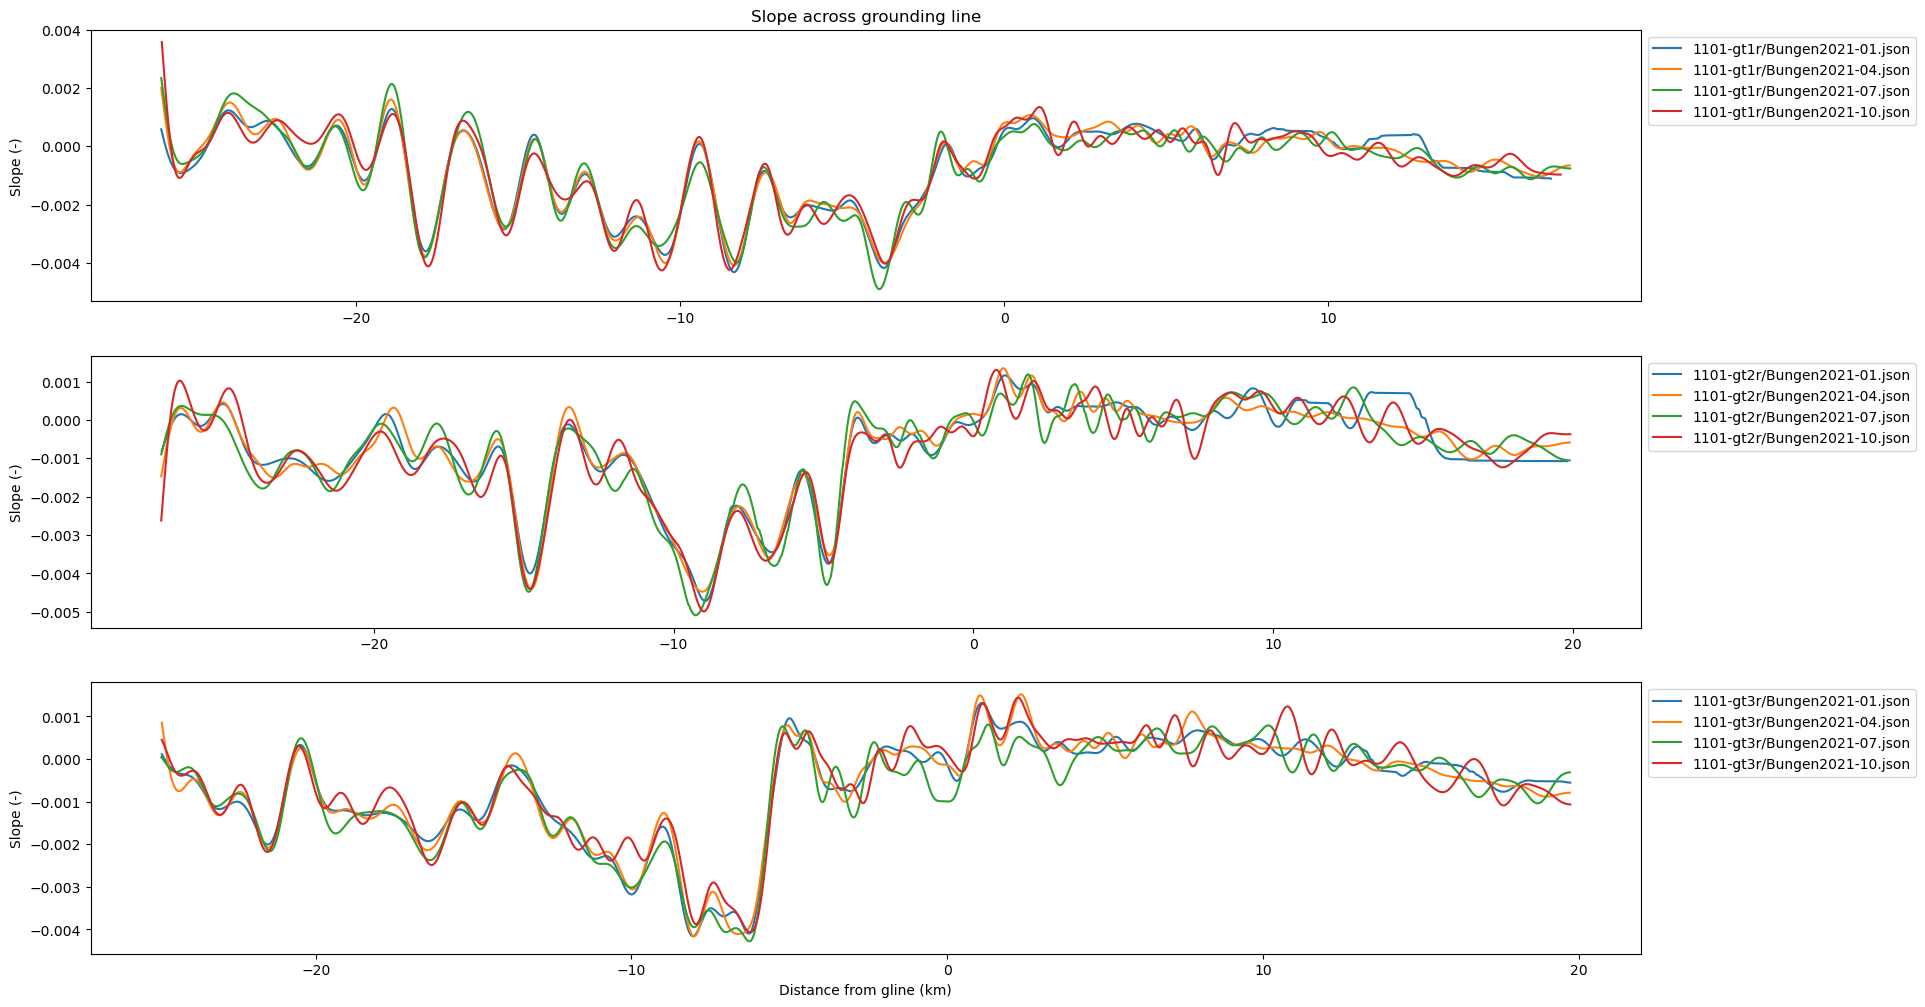

In [9]:
fig, ax = plt.subplots(3, 1, figsize = (20, 12))

i = 0
for beam in single_beams:
    j = 0
    for track in beam:
        ax[i].plot(track["gline_dist"], track["slope-filt"], label=f"{rgt}-{names[i]}{data_paths[j]}")
        j += 1
    ax[i].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    ax[i].set_ylabel("Slope (-)")
    i += 1
    
ax[2].set_xlabel("Distance from gline (km)")
ax[0].set_title("Slope across grounding line")
    
plt.show()

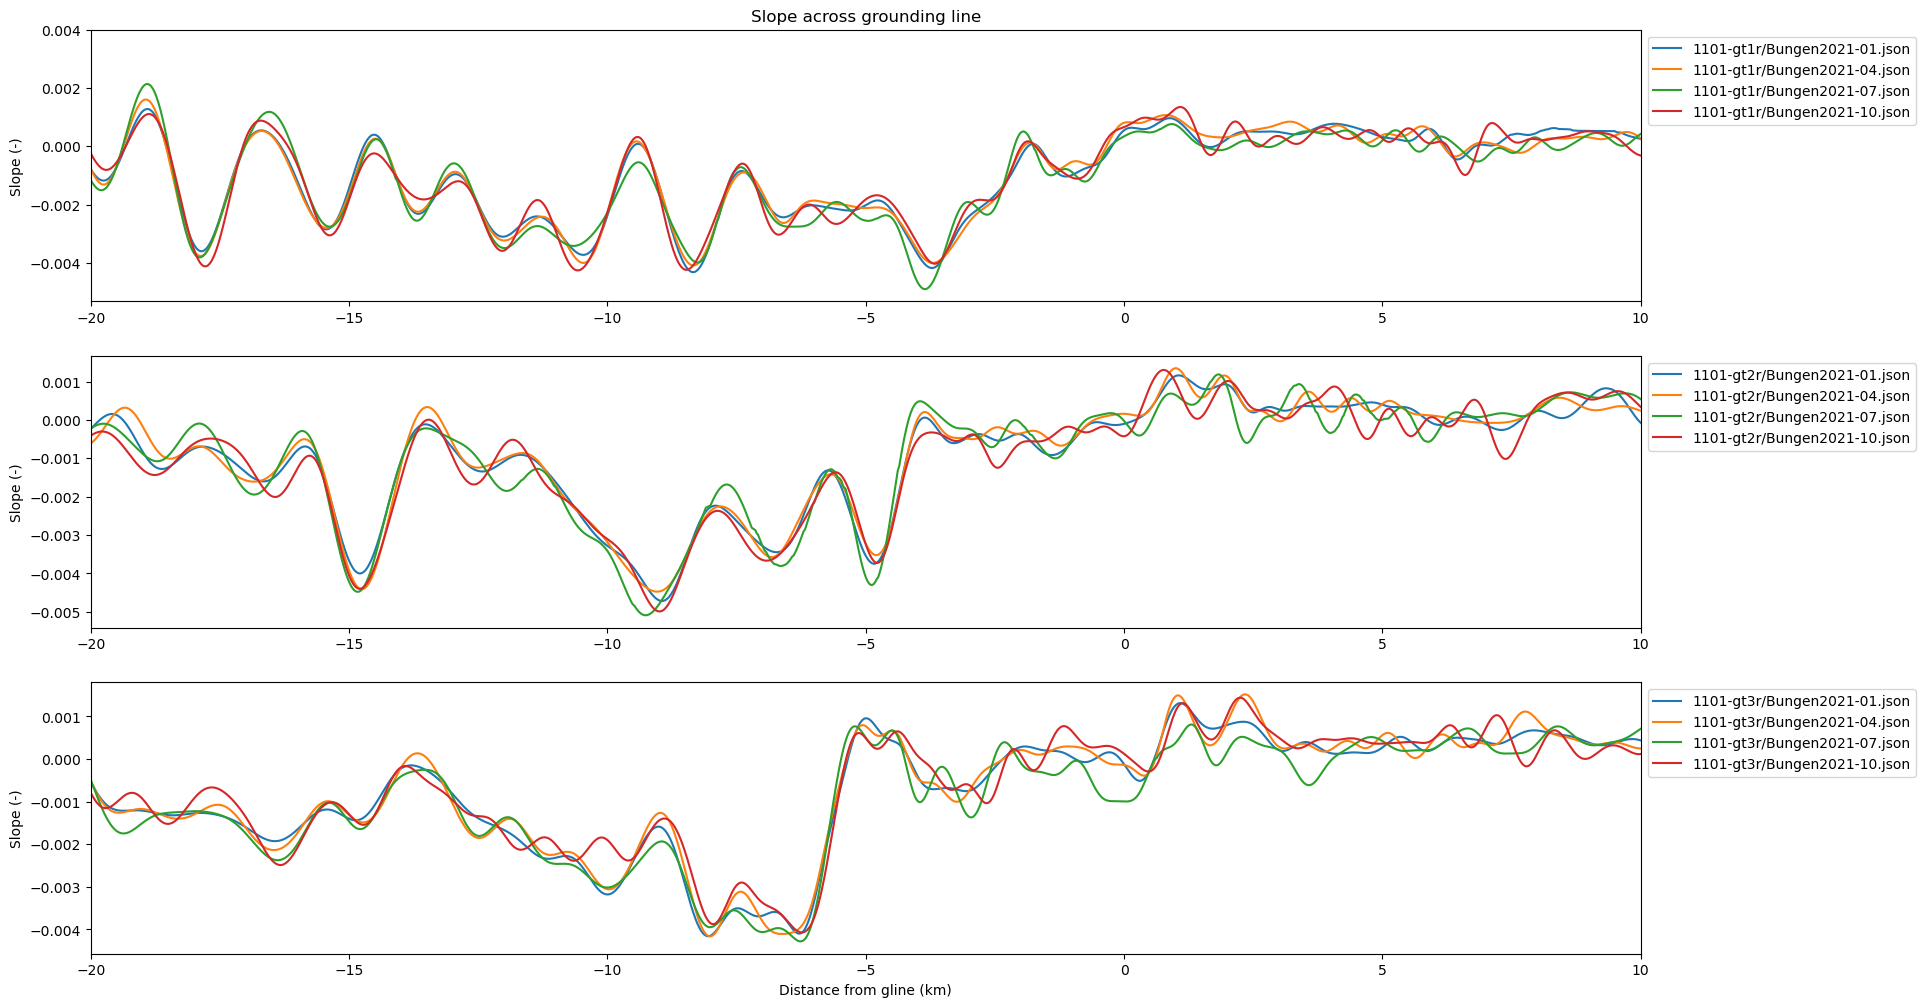

In [10]:
d_min = -20
d_max = 10

fig, ax = plt.subplots(3, 1, figsize = (20, 12))

i = 0
for beam in single_beams:
    j = 0
    for track in beam:
        ax[i].plot(track["gline_dist"], track["slope-filt"], label=f"{rgt}-{names[i]}{data_paths[j]}")
        j += 1
    ax[i].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    ax[i].set_ylabel("Slope (-)")
    ax[i].set_xlim(d_min, d_max)
    i += 1
    
ax[2].set_xlabel("Distance from gline (km)")
ax[0].set_title("Slope across grounding line")
    
plt.show()

# Cross correlate

In [11]:
from scipy import signal

In [12]:
cropped = [[],[],[]]
for i, beam in enumerate(single_beams):
    for track in beam:
        cropped[i].append(track[(track["gline_dist"] > d_min) & (track["gline_dist"] < d_max)])

### Visualize track proximity

In [13]:
scaled = [[], [], []]
res_scale = 50
idx_x = []

for i, croppy in enumerate(cropped):
    idx_x.append(np.linspace(croppy[0]["gline_dist"].min(), croppy[0]["gline_dist"].max(), num=len(croppy[0])*res_scale))

print(f"Transforming {len(cropped[0][0])} points into {len(cropped[0][0])*res_scale} points")
for i, crop in enumerate(cropped):
    for track in crop:
        out = np.interp(idx_x[i], track["gline_dist"], track["slope-filt"])
        scaled[i].append(out)
    
final_lag = [[], [], []]

for i, beam in enumerate(scaled):
    baseline = scaled[i][0]
    for track in beam:
        correlation = signal.correlate(baseline, track, mode="full")
        lags = signal.correlation_lags(len(baseline), len(track), mode="full")
        final_lag[i].append(lags[np.argmax(np.abs(correlation))])
    
print(f"Lags in terms of indices: {final_lag}")

d_dist = [np.diff(idx_x[0]), np.diff(idx_x[1]), np.diff(idx_x[2])]

med_delt_dist = [np.median(d_dist[0]), np.median(d_dist[1]), np.median(d_dist[2])]

lag_km = []
for i, lag_arr in enumerate(final_lag):
    lag_km.append(np.array(lag_arr) * med_delt_dist[i])
lag_km = np.array(lag_km)

print(f"Lags in meters: {lag_km * 1000}")

for i, crop in enumerate(cropped):
    for j, track in enumerate(crop):
        track["gline_dist"] = track["gline_dist"] + lag_km[i][j]

Transforming 2047 points into 102350 points
Lags in terms of indices: [[0, 8, 0, -20], [0, -63, 127, -59], [0, 0, 22, -267]]
Lags in meters: [[  0.           2.34347809   0.          -5.85869522]
 [  0.         -19.29629621  38.89888284 -18.07113455]
 [  0.           0.           6.51177496 -79.02926888]]


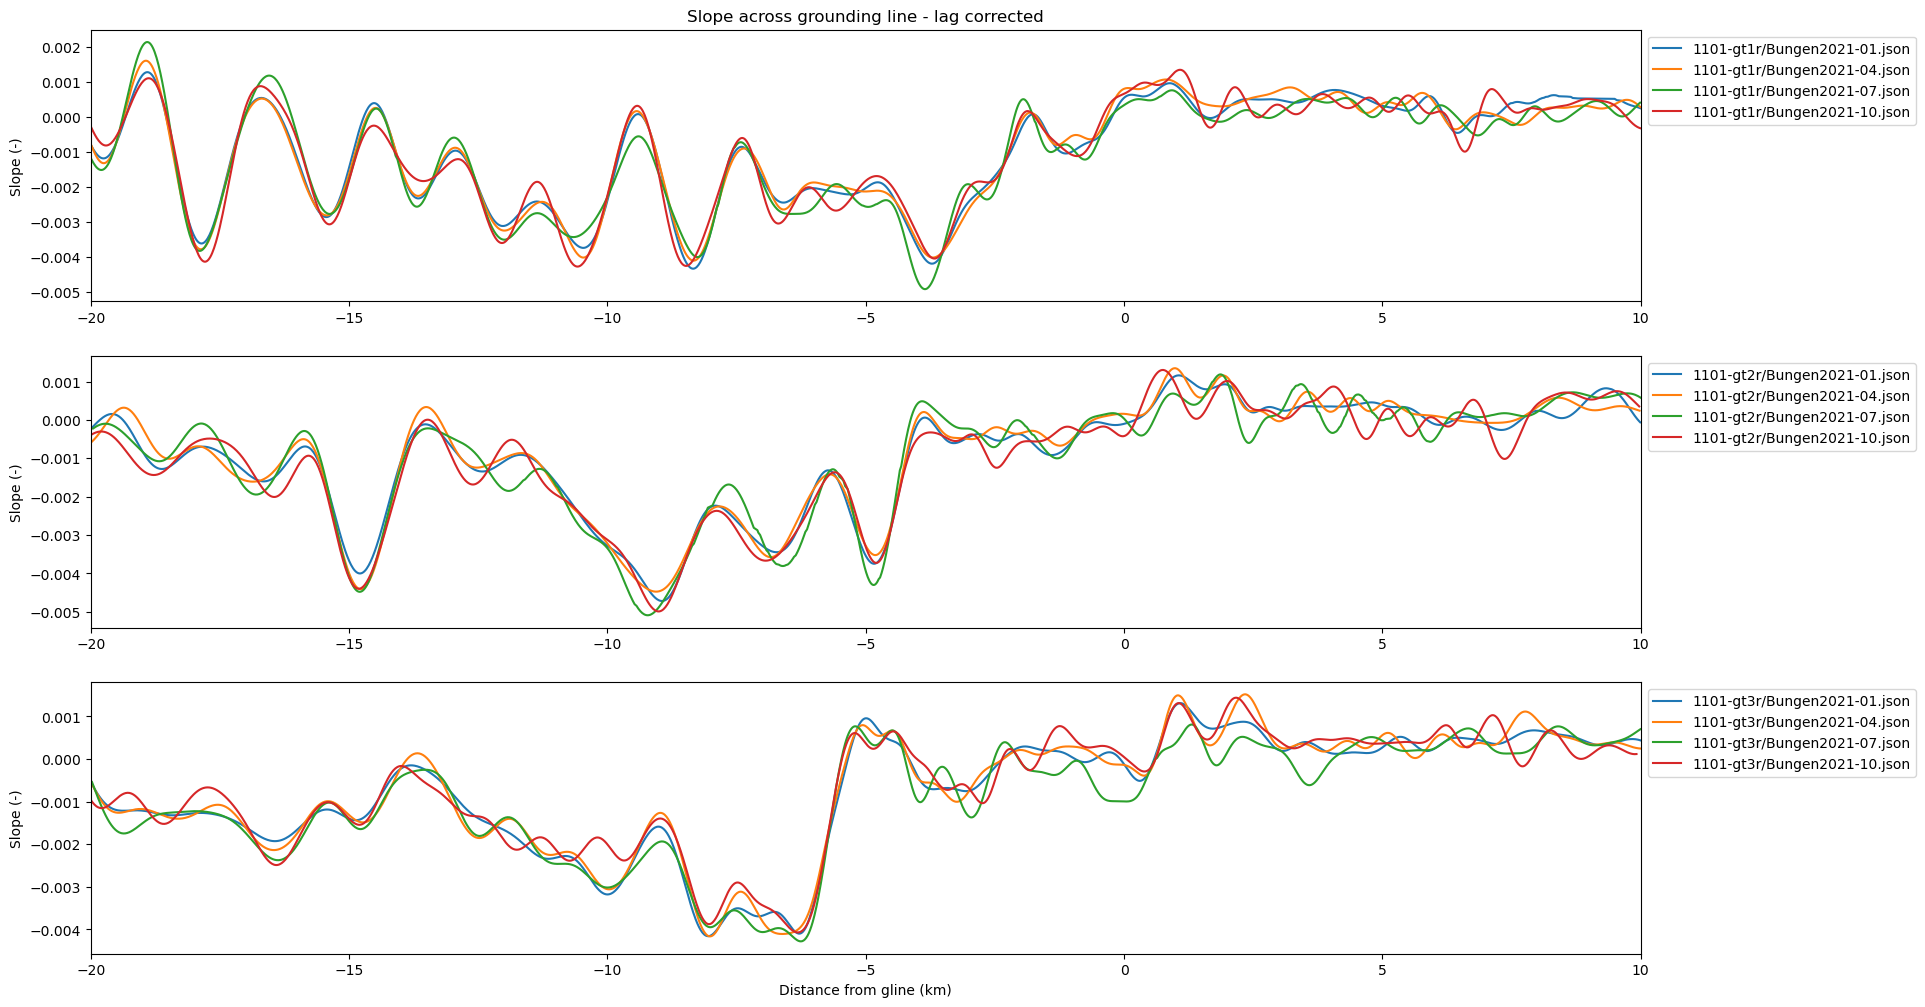

In [14]:
fig, ax = plt.subplots(3, 1, figsize = (20, 12))

i = 0
for crop in cropped:
    j = 0
    for track in crop:
        ax[i].plot(track["gline_dist"], track["slope-filt"], label=f"{rgt}-{names[i]}{data_paths[j]}")
        j += 1
    ax[i].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    ax[i].set_ylabel("Slope (-)")
    ax[i].set_xlim(d_min, d_max)
    i += 1
    
ax[2].set_xlabel("Distance from gline (km)")
ax[0].set_title("Slope across grounding line - lag corrected")
    
plt.show()

# Derivative?

In [15]:
for crop in cropped:
    for track in crop:
        track["gradient"] = np.gradient(track["slope-filt"])

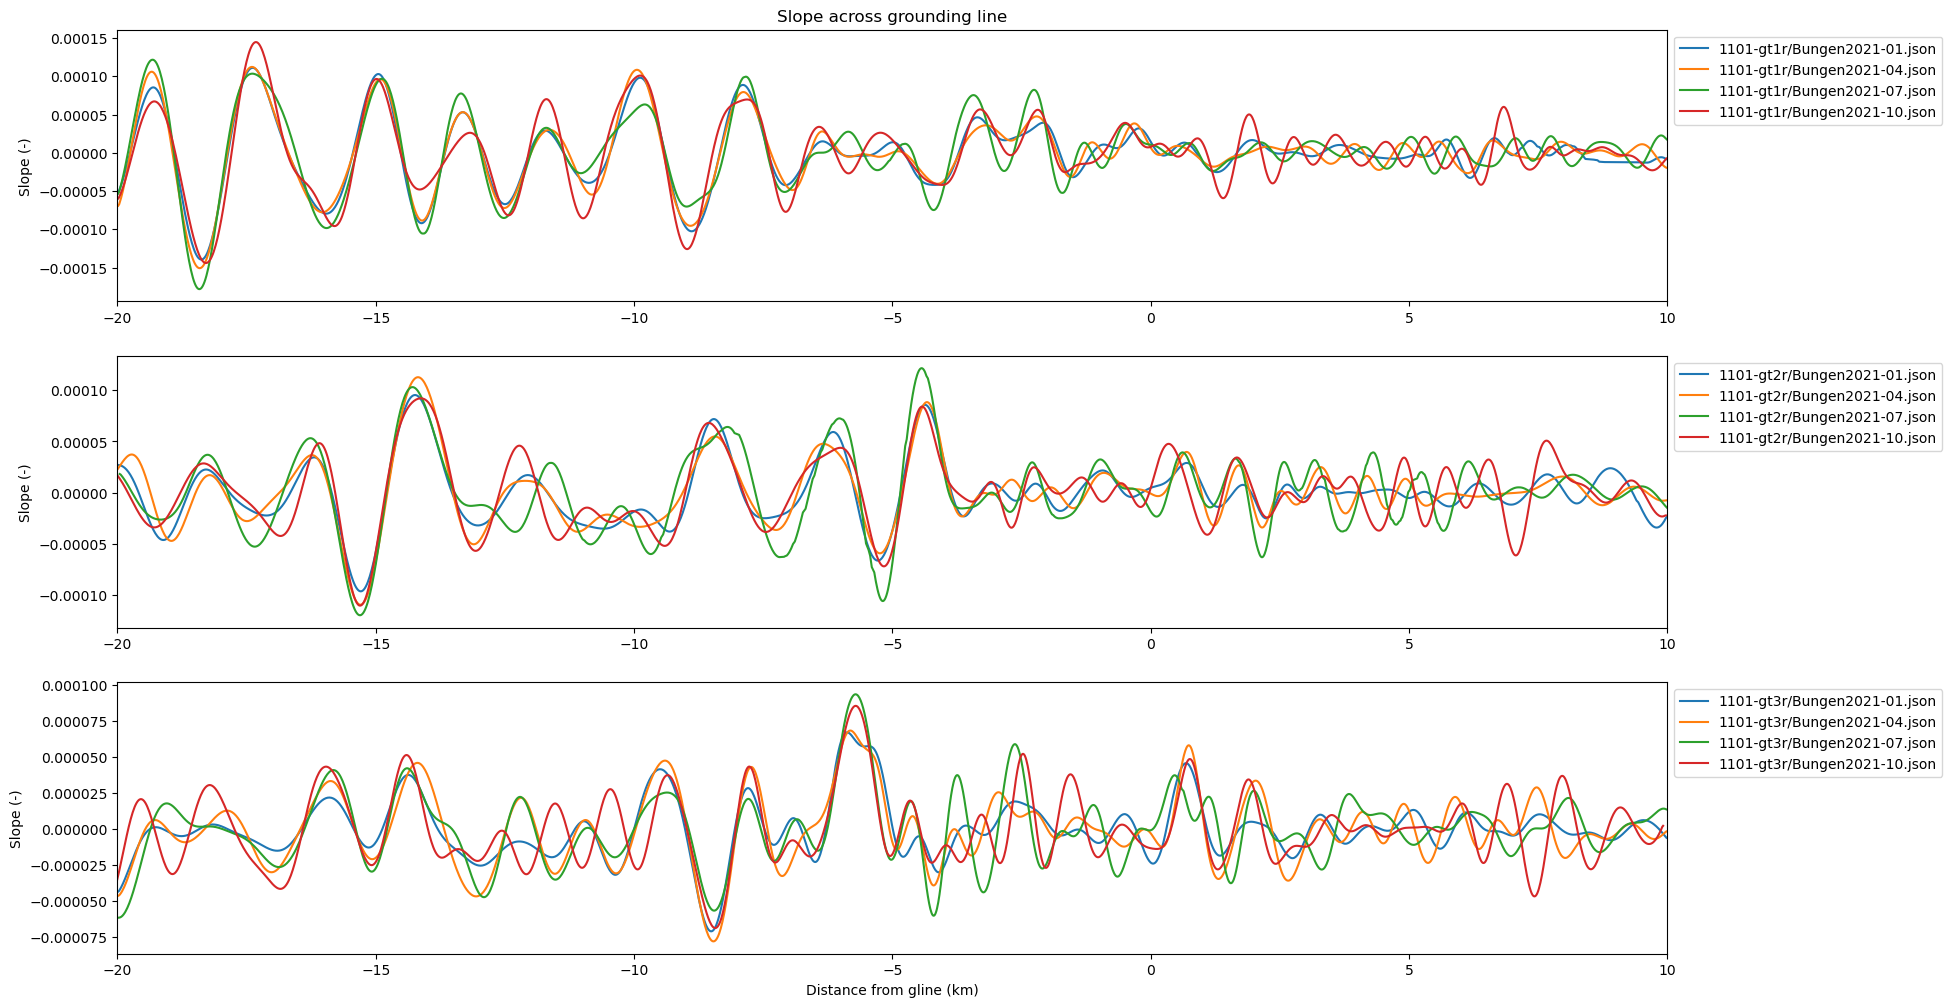

In [16]:
fig, ax = plt.subplots(3, 1, figsize = (20, 12))

i = 0
for crop in cropped:
    j = 0
    for track in crop:
        ax[i].plot(track["gline_dist"], track["gradient"], label=f"{rgt}-{names[i]}{data_paths[j]}")
        j += 1
    ax[i].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    ax[i].set_ylabel("Slope (-)")
    ax[i].set_xlim(d_min, d_max)
    i += 1
    
ax[2].set_xlabel("Distance from gline (km)")
ax[0].set_title("Slope across grounding line")
    
plt.show()

**The spots where there are more significant features tend to have a much lower difference between tracks when correlated**

In [17]:
from scipy.signal import find_peaks

In [18]:
idx = np.linspace(d_min, d_max, 5000)
interped = [[],[],[]]

dx = (d_max - d_min) / 5000

for i, crop in enumerate(cropped):
    for track in crop:
        slope_filt = np.interp(idx, track["gline_dist"], track["slope-filt"])
        gradient = np.interp(idx, track["gline_dist"], track["gradient"])
        df = pd.DataFrame(index = idx, data = {"gline_dist":idx, "slope-filt":slope_filt, "gradient":gradient})
        interped[i].append(df)

In [19]:
peaks = [[], [], []]
for i, interp in enumerate(interped):
    for track in interp:
        out = find_peaks(np.abs(track["gradient"]), height = 0.000065)
        dist_conv = np.array(out[0] * dx) - 20
        peaks[i].append((dist_conv, out[1]))

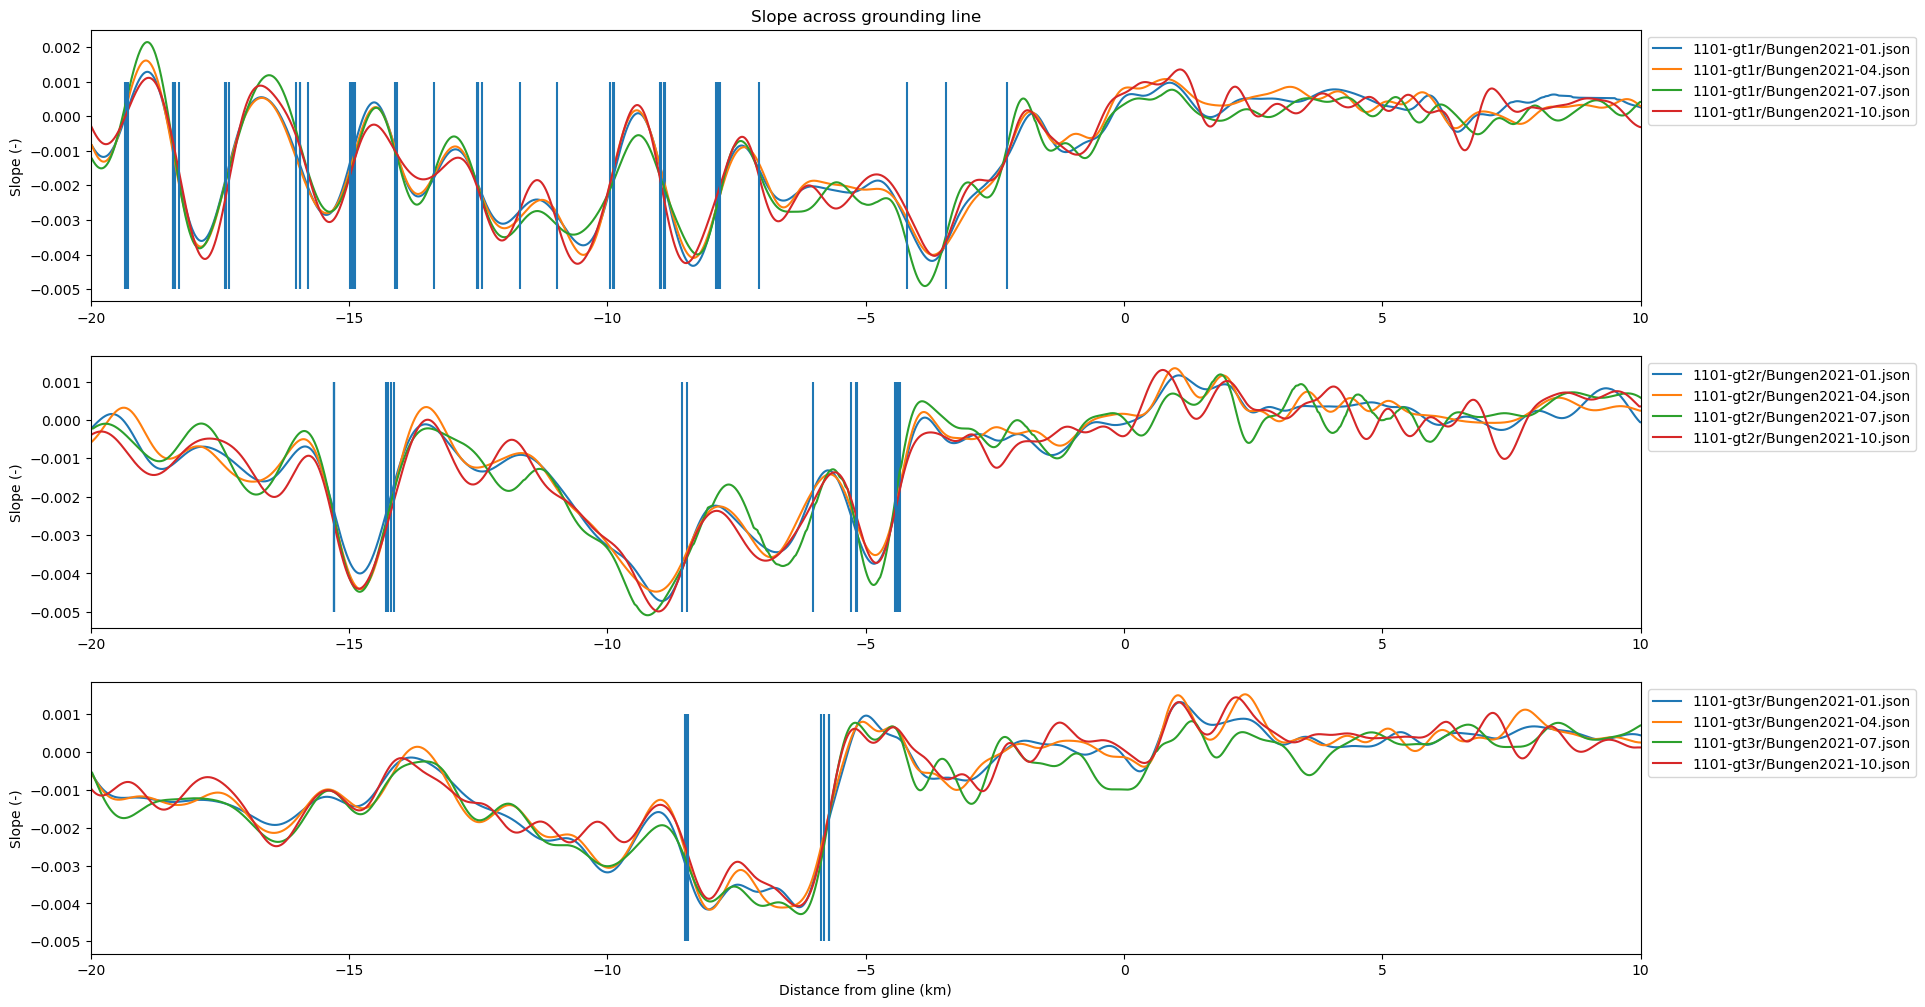

In [20]:
d_min = -20
d_max = 10

fig, ax = plt.subplots(3, 1, figsize = (20, 12))

v_id = 3 # index of line to display peaks from

i = 0
for i, interp in enumerate(interped):
    j = 0
    for track in interp:
        ax[i].plot(track["gline_dist"], track["slope-filt"], label=f"{rgt}-{names[i]}{data_paths[j]}")
        ax[i].vlines(peaks[i][j][0], ymin=-0.005, ymax=0.001)
        j += 1
    ax[i].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    ax[i].set_ylabel("Slope (-)")
    ax[i].set_xlim(d_min, d_max)
    i += 1
    
ax[2].set_xlabel("Distance from gline (km)")
ax[0].set_title("Slope across grounding line")
    
plt.show()

### Gather difference for slope

*Additionally reiterpolate all the data so it can really easily be correlated and compared*

In [21]:

slope_differences = []
baseline = 3
for crop in interped:
    # code for deviation
    average = (crop[0]["slope-filt"] + crop[1]["slope-filt"] + crop[2]["slope-filt"] + crop[3]["slope-filt"]) / 4
    deviation = np.sqrt(((crop[0]["slope-filt"] - average)**2 + (crop[1]["slope-filt"] - average)**2 + (crop[2]["slope-filt"] - average)**2 + (crop[3]["slope-filt"] - average)**2)/3)
    slope_differences.append(deviation)
    
    # code for difference
    #diff = 3 * crop[baseline]["slope-filt"] - crop[0]["slope-filt"] - crop[1]["slope-filt"] - crop[2]["slope-filt"]
    #slope_differences.append(diff)

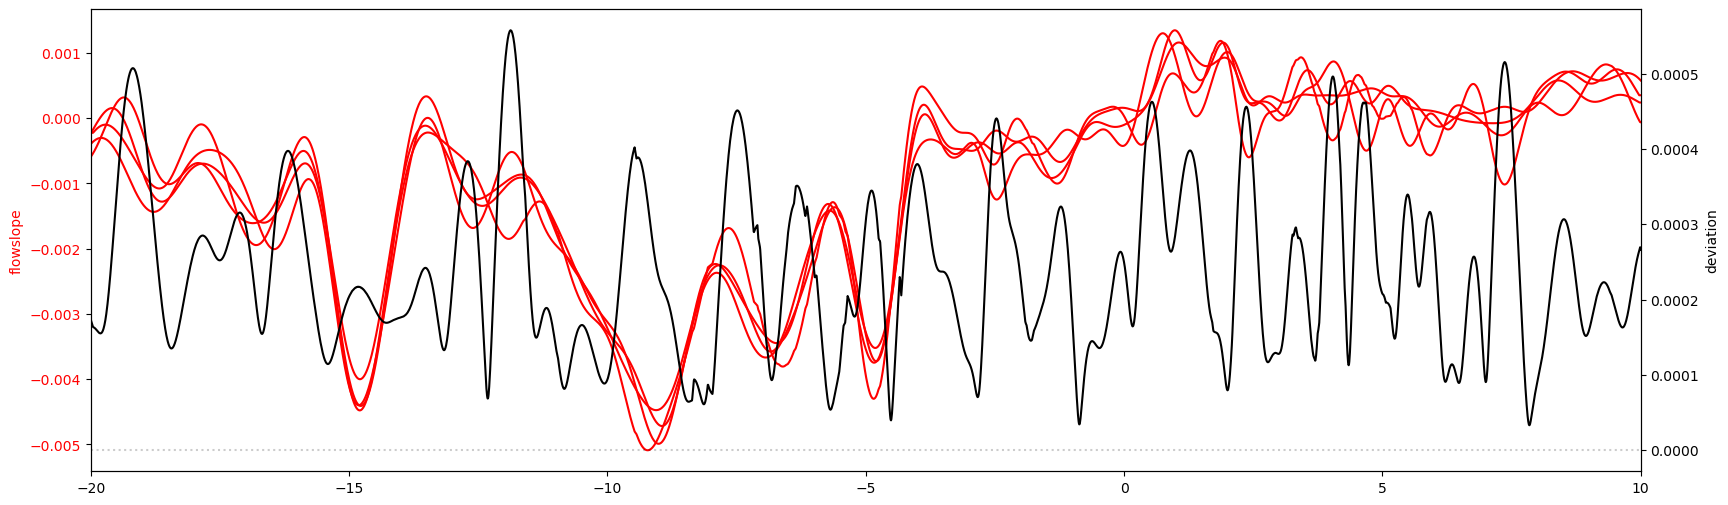

In [22]:
i = 1

fig, ax1 = plt.subplots(1, 1, figsize = (20, 6))

color = 'red'
ax1.set_ylabel('flowslope', color=color)  # we already handled the x-label with ax1
for j, track in enumerate(interped[i]):
    ax1.plot(track["gline_dist"], track["slope-filt"], c=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.hlines(0, xmin=d_min, xmax=d_max, colors="black", linestyles="dotted", alpha=0.2)

color = "black"
ax2.plot(idx, slope_differences[i], color=color)
ax2.set_ylabel('deviation', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

plt.xlim(d_min, d_max)

plt.show()

# Detecting point F (limit of tidal flexure)

https://doi.org/10.5194/tc-2022-265 uses the point where the elevation deviates from the reference elevation. Reference elevation is when the tide is 0. Then the pick the nearest peak of the 2nd derivative of elevationa as the point of tidal flexure. Here this can be understood as the first deriv of flowslope.